### Import neccesary libraries

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from oemof import solph
from oemof.tools import economics

### 1) Import data

In [2]:
load_profile = pd.read_csv("data/exam_project_profiles.csv", index_col=0)
print("the length of the data is: ", len(load_profile))
load_profile.head()

the length of the data is:  8760


,Pel kW,Pth kW
0,0.289583,0.398678
1,0.285012,0.393958
2,0.271620,0.383260
3,0.278819,0.394840
4,0.267483,0.388232


In [3]:
# Generate hourly datetimes for a whole year
date_range = pd.date_range(start='2023-01-01', periods=8760, freq='h')
load_profile.index = date_range
load_profile.head()

,Pel kW,Pth kW
2023-01-01 00:00:00,0.289583,0.398678
2023-01-01 01:00:00,0.285012,0.393958
2023-01-01 02:00:00,0.271620,0.383260
2023-01-01 03:00:00,0.278819,0.394840
2023-01-01 04:00:00,0.267483,0.388232


In [4]:
pv_data = pd.read_csv('data/pv_complete_profile.csv', parse_dates=['time'], index_col=0) # P in watts
pv_data.head()

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
2023-01-01 00:10:00,0.0,0.0,0.0,9.14,2.90,0.0
2023-01-01 01:10:00,0.0,0.0,0.0,9.13,2.90,0.0
2023-01-01 02:10:00,0.0,0.0,0.0,9.09,2.76,0.0
2023-01-01 03:10:00,0.0,0.0,0.0,9.04,2.76,0.0
2023-01-01 04:10:00,0.0,0.0,0.0,9.00,2.76,0.0


In [5]:
from datetime import timedelta

# remove the 10 min from each time value so it matches the profile data
pv_data.index = pv_data.index - timedelta(minutes=10)
pv_data.head()

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
2023-01-01 00:00:00,0.0,0.0,0.0,9.14,2.90,0.0
2023-01-01 01:00:00,0.0,0.0,0.0,9.13,2.90,0.0
2023-01-01 02:00:00,0.0,0.0,0.0,9.09,2.76,0.0
2023-01-01 03:00:00,0.0,0.0,0.0,9.04,2.76,0.0
2023-01-01 04:00:00,0.0,0.0,0.0,9.00,2.76,0.0


In [6]:
# Truncate date to only the first quarter of the year
months_subset = None
all_months = list(range(1,13))
pv_data = pv_data.loc[pv_data.index.month.isin(months_subset or all_months)]
load_profile = load_profile.loc[load_profile.index.month.isin(months_subset or all_months)]

### 2) Define boundary conditions

In [7]:
pth_load = 550  # scaling factor for heat load profile in kW
pel_load = 250  # scaling factor for electrical load profile in kW

pv_nominal_value = 356 # kWp

# Boiler boundary conditions
pth_boiler = 240 # thermal power output of boiler in kW
eta_boiler = 0.91 # efficiency of boiler
 
# Heat pump boundary conditions Viessmann Vitocal 300 G pro 135.3kW capacity
pth_hp = 169.5 # thermal power output of heat pump in kW

# Alternatively, the electric input of the heat pump can be set
# pel_hp = None # electric power input of the heat pump in kW
COP_real_hp = 3 # COP of the heat pump
COP_hp = COP_real_hp
# CHP boundary conditions 
# pth_chp_el = 100 # electric power output of CHP in kW
# pth_chp_th = 173 # thermal power output of CHP in kW
# eta_chp_el = 0.367 # electric efficiency of CHP in %
# eta_chp_th = 0.611 # thermal efficiency of CHP in %

Qth_store = 1000 # capacity of thermal storage in kWh
 
price_ngas = 0.04 # gas price in €/kWh
price_el = 0.35 # electricity price in €/kWh
price_el_lc = 0.25 # electricity price for large consumers in €/kWh
 
# CO2 emission factor
fco2_el = 560 # unit g/kWh
fco2_gas = 240 # unit g/kWh
# CO2_limit = 10000 # unit kg

min_therm_storage = 0.2 # minimum state of charge of thermal storage
min_batt_storage = 0.2 # minimum state of charge of battery

charge_power = pel_load # Charging power battery in kW
discharge_power = pel_load # Discharging power in kW
batt_store_cap = 48 # Battery capacity in kWh
batt_init_level = 0.5 # Initial state of charge of battery

feed_in_tariff = -0.06 # €/kWh

max_fossil_fuel = 0.35 # maximum share of fossil fuel in heat production

folder = "results_cost_1_euros"


In [8]:
# # co2 optimization cost values
# price_el = fco2_el
# price_el_lc = fco2_el
# price_ngas = fco2_gas
# folder = "results_cost_1_co2"

### 3) Define energy system model with buses and components

In [9]:
es = solph.EnergySystem(
    timeindex=load_profile.index,
    infer_last_interval=True
)

In [10]:
bngas = solph.Bus(label='bgas') # gas bus
bth = solph.Bus(label='bth') # thermal bus
bel_pv = solph.Bus(label='bel_pv') # electrical bus for PV output
bel = solph.Bus(label='bel') # electrical bus
bel_hp = solph.Bus(label='bel_hp') # electrical bus for Heat Pump
# bth_constraint = solph.Bus(label='bth_constraint') # thermal bus for the 35% constraint

es.add(bth, bel, bel_hp, bel_pv, bngas)

In [11]:
# natural gas supply from public gas grid
supply_ngas = solph.components.Source(
    label='supply_ngas',
    outputs={bngas: solph.Flow(variable_costs=price_ngas)},
    custom_attributes={'emission_factor': fco2_gas / 1000}
) 

# electricity supply from public grid
egrid = solph.components.Source(
    label='grid',
    outputs={bel: solph.Flow(variable_costs=price_el)},
    custom_attributes={'emission_factor': fco2_el / 1000}
)

# electricity supply from public grid to the heat pump
egrid_hp = solph.components.Source(
    label='grid_hp',
    outputs={bel_hp: solph.Flow(variable_costs=price_el_lc)},
    custom_attributes={'emission_factor': fco2_el / 1000}
)

# electricity supply from pv system
pv_system = solph.components.Source(
    label='pv', 
    outputs={
        bel_pv: solph.flows.Flow(
        fix=pv_data['P'] / (pv_nominal_value * 1000), 
        nominal_value=pv_nominal_value)
    },
    custom_attributes={'emission_factor': 0}
)

es.add(egrid, egrid_hp, pv_system, supply_ngas)

In [12]:
# sink heat load
heat_demand = solph.components.Sink(
    label='demand_heat',
    inputs={bth: solph.Flow(fix=load_profile['Pth kW'], nominal_value=pth_load)},
)

# sink electricity load
el_demand = solph.components.Sink(
    label='demand_el',
    inputs={bel: solph.Flow(fix=load_profile['Pel kW'], nominal_value=pel_load)}
)

# sink heat excess
# heat_excess = solph.components.Sink(
#     label='heat_excess',
#     inputs={bth: solph.Flow()}
# )

# sink electricity excess
# el_excess = solph.components.Sink(
#     label='el_excess',
#     inputs={bel: solph.Flow()}
# )


grid_feed = solph.components.Sink(
    label='grid_feed',
    inputs={bel_pv: solph.Flow(variable_costs=feed_in_tariff)})


es.add(heat_demand, el_demand, grid_feed)

In [13]:
# boiler
boiler_out_flow = solph.Flow(nominal_value=pth_boiler, custom_attributes={"fossil_fuel": 1/max_fossil_fuel},)
boiler = solph.components.Converter(
    label='boiler',
    inputs={bngas: solph.Flow()},
    outputs={bth: boiler_out_flow},
    conversion_factors={bngas: 1/eta_boiler},
)

pv_splitter_demand = solph.components.Converter(
    label='pv_splitter_demand',
    inputs={bel_pv: solph.Flow(nominal_value=pv_nominal_value)},
    outputs={bel: solph.Flow(),}
)


pv_splitter_hp = solph.components.Converter(
    label='pv_splitter_hp',
    inputs={bel_pv: solph.Flow(nominal_value=pv_nominal_value)},
    outputs={bel_hp: solph.Flow()},
)

# Heat Pump
hp = solph.components.Converter(
    label='heat_pump',
    inputs={bel_hp: solph.Flow()},
    outputs={bth: solph.Flow(
        nominal_value=pth_hp,
        min=0.2,
        max=1.0,
        nonconvex=solph.NonConvex(
            minimum_uptime=6,
            minimum_downtime=2,
            initial_status=1
        ),
    )},
    conversion_factors={bel_hp: 1/COP_hp}
)


es.add(hp, pv_splitter_demand, pv_splitter_hp, boiler)

In [14]:
# thermal storage
therm_store = solph.components.GenericStorage(
    label='storage_thermal',
    nominal_storage_capacity=Qth_store,
    inputs={bth: solph.Flow()},
    outputs={bth: solph.Flow()},
    initial_storage_level=0.5,
    min_storage_level=min_therm_storage,
    balanced=True
)

# Define battery storage
estore = solph.components.GenericStorage(
    label='estore',
    nominal_storage_capacity=batt_store_cap,
    inputs={bel: solph.Flow(nominal_value=charge_power)},
    outputs={bel: solph.Flow(nominal_value=discharge_power)},
    initial_storage_level=batt_init_level,
    min_storage_level=min_batt_storage,
    balanced=True
)

es.add(therm_store, estore)

In [15]:
# build model

om = solph.Model(es)

In [16]:
flow_with_keyword = {(boiler, bth): boiler_out_flow, }
om = solph.constraints.generic_integral_limit(
    om, 
    "fossil_fuel", 
    flow_with_keyword,
    upper_limit=load_profile['Pth kW'].sum() * pth_load
)

### 4) Solve MILP problem

In [17]:
import multiprocessing as mp
from pyomo.opt import SolverFactory

# 1. Enable parallel processing
threads = int(mp.cpu_count() / 2)  # Leave one core free

# 3. Configure solver with optimized parameters
optimizer = SolverFactory('cbc')  # or 'gurobi' if available
# optimizer = SolverFactory('cplex')
solver_options = {
    'threads': threads,   # Parallelize across all CPU cores
    'ratio': 0.01,               # Acceptable MIP gap (1%); higher gap => faster, less precise
    'seconds': 3600 * 2,             # Time limit (sec); ensures solver stops if too long
    'presolve': 'on',            # Simplifies problem before solving; speeds up solution
    'randomCbcSeed': 1           # Deterministic runs
}


result = optimizer.solve(om, 
                       tee=True,
                       keepfiles=False,
                       options=solver_options)

# om.solve(solver='cbc', solve_kwargs={'tee': True, 'threads': threads})

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -threads 8 -ratio 0.01 -seconds 7200 -presolve on -randomCbcSeed 1 -printingOptions all -import /tmp/tmp8eit86zl.pyomo.lp -stat=1 -solve -solu /tmp/tmp8eit86zl.pyomo.soln (default strategy 1)
threads was changed from 0 to 8
ratioGap was changed from 0 to 0.01
seconds was changed from 1e+100 to 7200
randomCbcSeed was changed from -1 to 1
Option for printingOptions changed from normal to all
Presolve 69379 (-88288) rows, 94787 (-97927) columns and 290092 (-174092) elements
Statistics for presolved model
Original problem has 8754 integers (8754 of which binary)
Presolved problem has 8754 integers (8754 of which binary)
==== 59835 zero objective 8 different
4688 variables have objective of -0.0833333
4130 variables have objective of -0.06
4624 variables have objective of -0.0393773
59835 variables have objective of 0
3990 variables have objective of 0.043956
4630 variables have objective 

### 5) Analyse results

In [18]:
# Read results
profiles = solph.processing.results(om)

In [19]:
import json
import os

# Check if the folder exists, if not, create it
if not os.path.exists(folder):
    os.makedirs(folder)


# Save the dictionary as a JSON file

with open(os.path.join(folder,'result.json'), 'w') as json_file:
    json.dump(result.json_repn(), json_file)

buses_to_save = ['bel', "bel_hp", "bth", "bgas", "bel_pv"]
for bus in buses_to_save:
    res = solph.views.node(profiles, bus)['sequences']
    flow_cols = [col for col in res.columns if 'flow' in col]
    res[flow_cols].to_csv(os.path.join(folder,f"{bus}.csv"))

<Axes: >

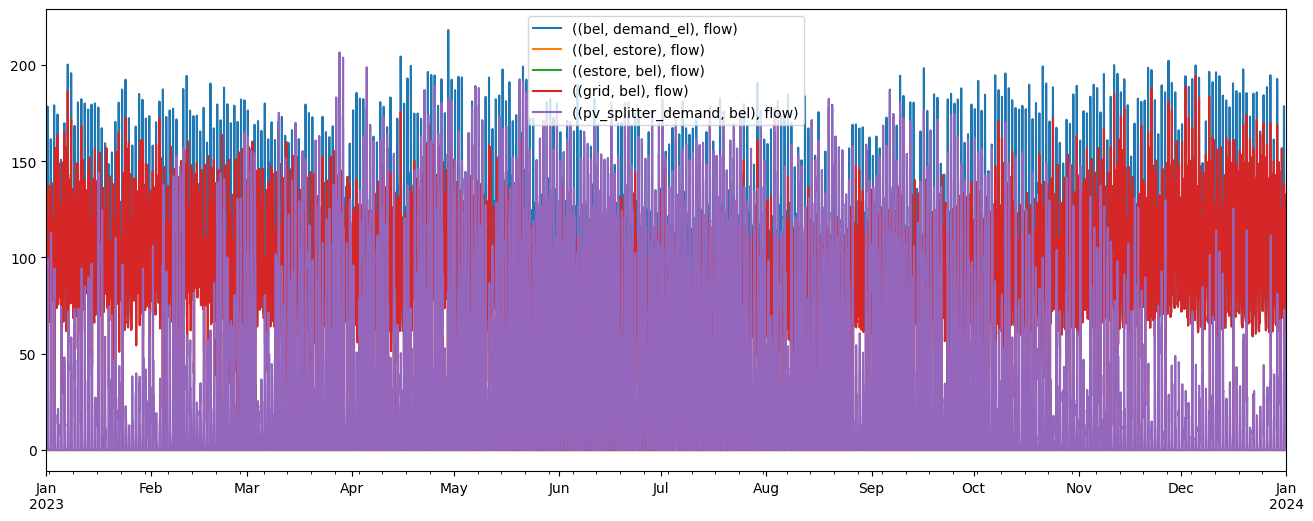

In [20]:
# read results for thermal bus and plot
res_bel = solph.views.node(profiles,'bel')['sequences']
flow_cols = [col for col in res_bel.columns if 'flow' in col]
res_bel[flow_cols].plot(figsize=(16,6))

<Axes: >

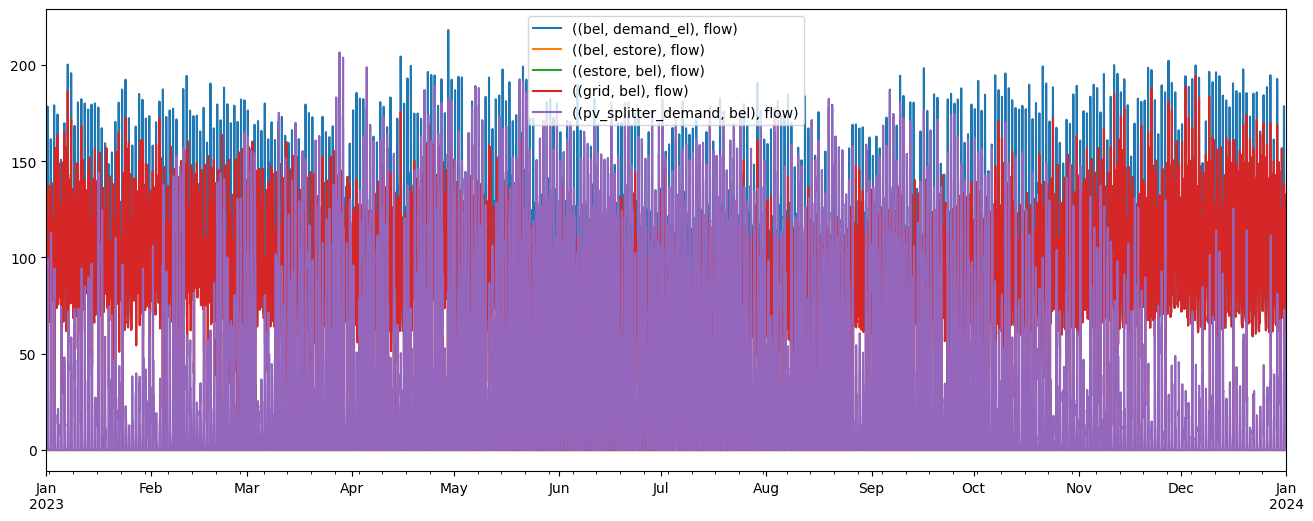

In [21]:
# read results for thermal bus and plot
res_bel = solph.views.node(profiles,'bel')['sequences']
flow_cols = [col for col in res_bel.columns if 'flow' in col]
res_bel[flow_cols].plot(figsize=(16,6))

In [22]:
res_bel.sum()

((bel, demand_el), flow)             877101.494652
((bel, estore), flow)                 10266.292650
((estore, bel), flow)                 10266.292658
((grid, bel), flow)                  595556.225946
((pv_splitter_demand, bel), flow)    281545.268475
dtype: float64

<Axes: >

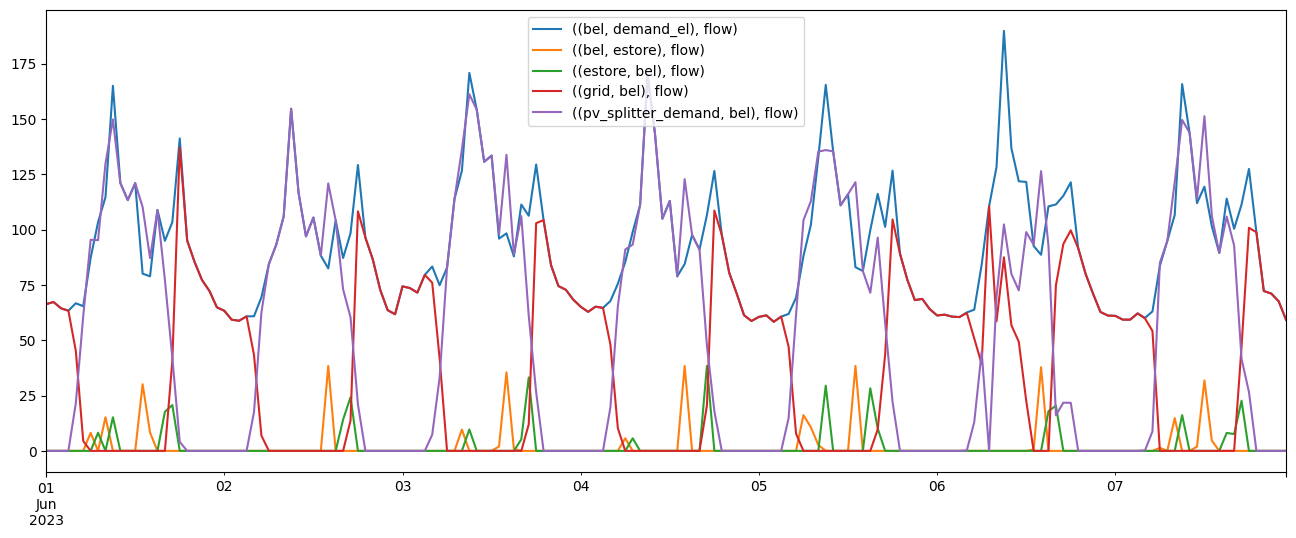

In [23]:
# Display january 1st and 2nd only
res_bel[
    (res_bel.index.year == 2023)
    & (res_bel.index.month == 6)
    & (res_bel.index.day.isin([1,2,3,4, 5, 6, 7]))
].plot(figsize=(16,6))

<Axes: >

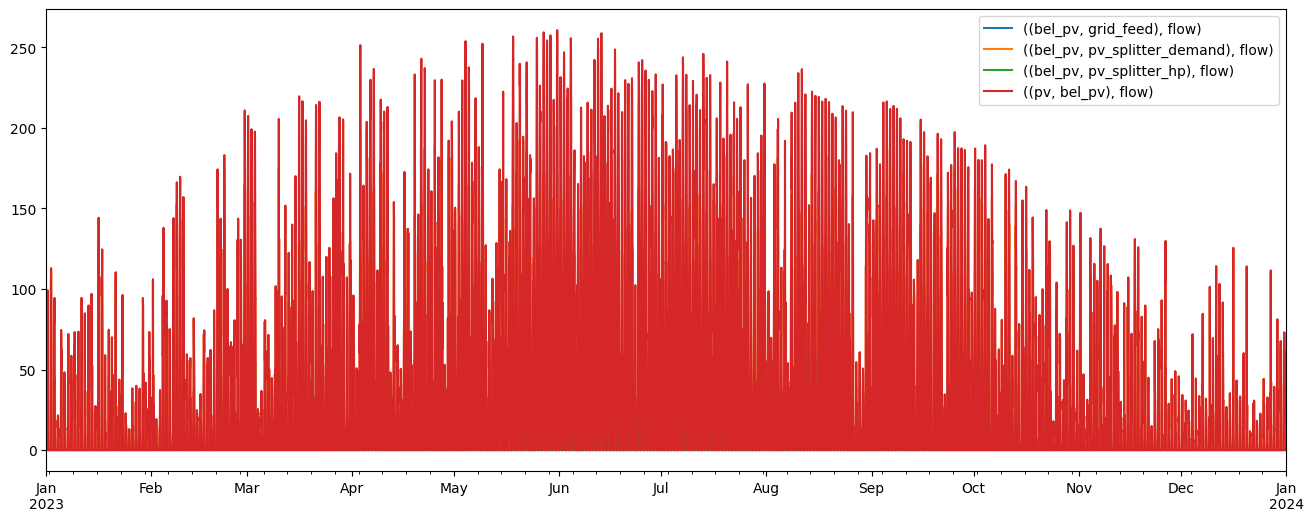

In [24]:
# read results for thermal bus and plot
res_bel = solph.views.node(profiles,'bel_pv')['sequences']
res_bel.plot(figsize=(16,6))

In [25]:
res_bel.sum()

((bel_pv, grid_feed), flow)              11470.753561
((bel_pv, pv_splitter_demand), flow)    281545.268475
((bel_pv, pv_splitter_hp), flow)         44157.486974
((pv, bel_pv), flow)                    337173.508980
dtype: float64

<Axes: >

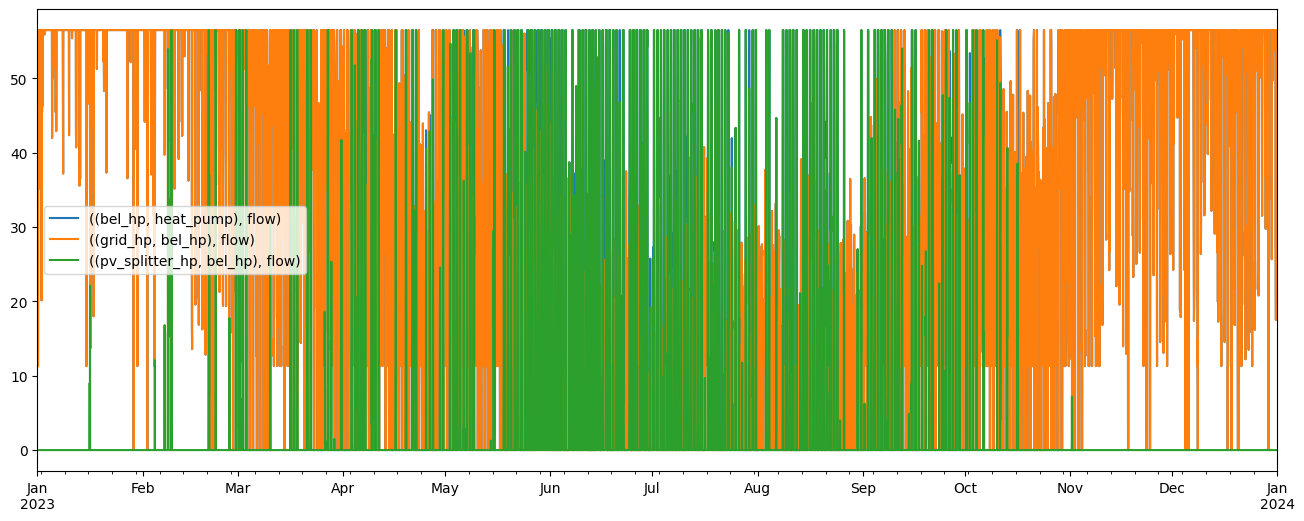

In [26]:
# read results for thermal bus and plot
res_bel = solph.views.node(profiles,'bel_hp')['sequences']
flow_cols = [c for c in res_bel.columns if "flow" in c]
res_bel[flow_cols].plot(figsize=(16,6))

<Axes: >

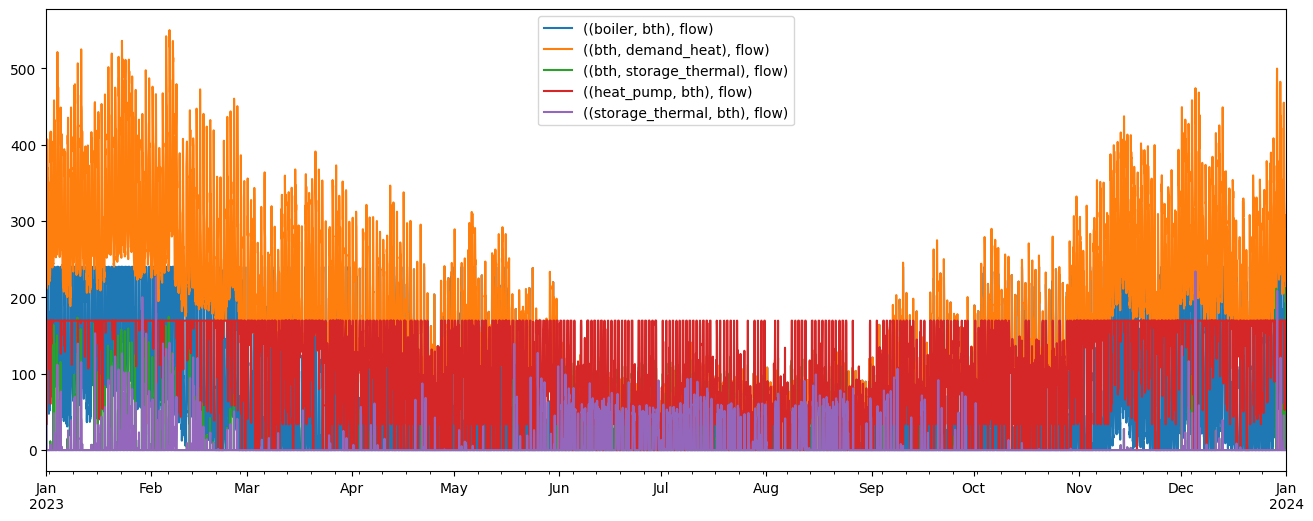

In [27]:
# read results for thermal bus and plot
res_bth = solph.views.node(profiles,'bth')['sequences']
flow_cols = [c for c in res_bth.columns if "flow" in c]
res_bth[flow_cols].plot(figsize=(16,6))

<Axes: >

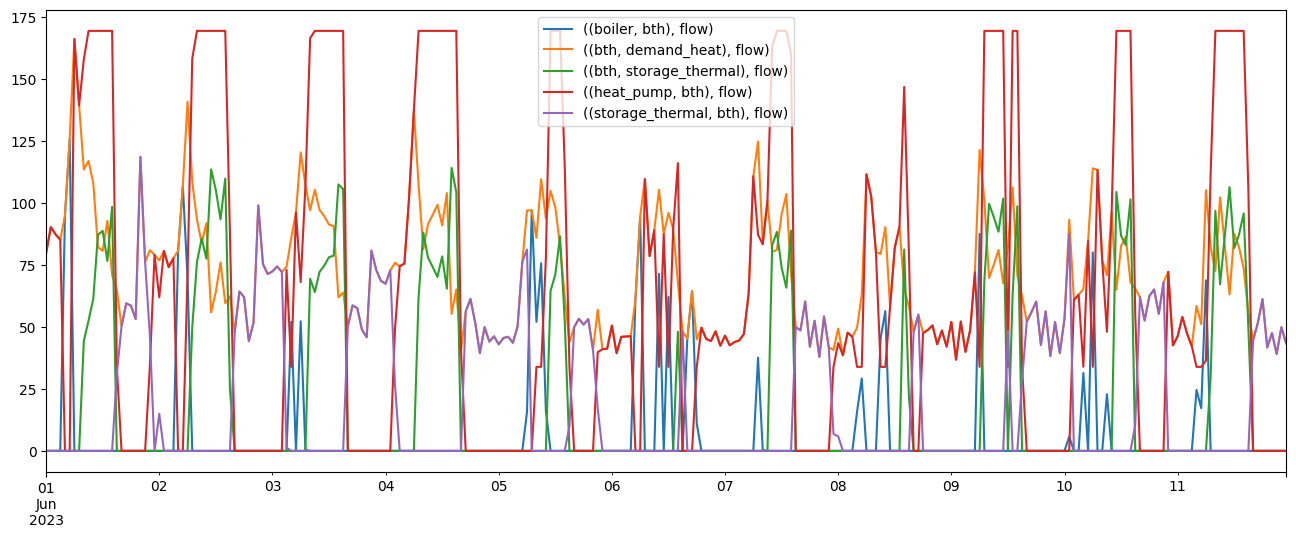

In [28]:
# Display january 1st and 2nd only
res_bth[flow_cols][
    (res_bth.index.year == 2023)
    & (res_bth.index.month == 6)
    & (res_bth.index.day.isin([1, 2, 3, 4, 5, 6, 7, 8, 9 ,10 ,11 ]))
].plot(figsize=(16,6))

In [29]:
res_bth.sum()

((boiler, bth), flow)                 5.003174e+05
((bth, demand_heat), flow)            1.429478e+06
((bth, storage_thermal), flow)        5.311780e+04
((heat_pump, bth), flow)              9.291609e+05
((heat_pump, bth), status)            7.437000e+03
((heat_pump, bth), status_nominal)    1.260572e+06
((storage_thermal, bth), flow)        5.311780e+04
dtype: float64

In [30]:
energy_supplied_hp = res_bth[(('heat_pump', 'bth'), 'flow')].sum() / res_bth.iloc[:,1].sum()
energy_supplied_boiler = res_bth[(('boiler', 'bth'), 'flow')].sum() / res_bth.iloc[:,1].sum()
print(f"Energy supplied by heat pump: {energy_supplied_hp:.2f}\nEnergy supplied by boiler: {energy_supplied_boiler:.2f}")

Energy supplied by heat pump: 0.65
Energy supplied by boiler: 0.35
